In [1]:
import os
cwd = os.getcwd()

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import psutil
psutil.virtual_memory()

svmem(total=33731371008, available=30757302272, percent=8.8, used=2245894144, free=30240862208, active=2070786048, inactive=906203136, buffers=1064960, cached=1243549696, shared=191905792, slab=130351104)

In [3]:
from synthdata_utils import grid_torus, scalar_field, noisy_scalar_field, toroidal_to_cart_coord
from synthdata_utils import cart_to_toroidal_coord, onemode_scalar_field, noisy_onemode_scalar_field

In [4]:
"""
Generating the synthetic data without noise
"""
gridsynth = grid_torus(ngrid_cart = 250, ngrid_tor = 250, R0 = 2)
synthfield_tor = scalar_field(R = gridsynth.R, 
                              theta = gridsynth.theta, 
                              phi = gridsynth.phi)
synthfield_tor_simple = onemode_scalar_field(R = gridsynth.R, 
                                             theta = gridsynth.theta, 
                                             phi = gridsynth.phi, 
                                             nmodes_phi = 3, nmodes_theta = 3)

#do it on a cartesian example
R1,theta1,phi1 = cart_to_toroidal_coord(x = gridsynth.cart_x, y = gridsynth.cart_y, z = gridsynth.cart_z)
synthfield_cart = scalar_field(R = R1, theta = theta1, phi = phi1)
synthfield_cart_simple = onemode_scalar_field(R = R1, theta = theta1, phi = phi1, 
                                              nmodes_phi = 3, nmodes_theta = 3)

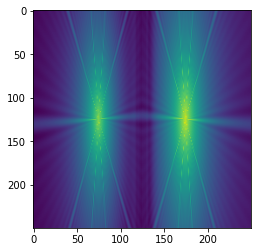

In [5]:
plt.imshow(synthfield_cart.T[::-1][:,124])

In [6]:
with open('%s/synthdata3/truefield_cart_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, synthfield_cart)
f.close()

with open('%s/synthdata3/truefield_cart_simple_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, synthfield_cart_simple)
f.close()

In [7]:
"""
Generating the synthetic data with noise, the point is to get something similar to the emc3 simulation,
where you have different noise for each iteration.
"""
noisy_tor = []
noisy_tor_simp = []
noisy_cart = []
noisy_cart_simp = []
for t in range(20):
    noisy_synthfield_tor = noisy_scalar_field(R = gridsynth.R,
                                              theta = gridsynth.theta, 
                                              phi = gridsynth.phi)
    noisy_tor.append(noisy_synthfield_tor)
    noisy_synthfield_tor_simple = noisy_onemode_scalar_field(R = gridsynth.R, 
                                                             theta = gridsynth.theta, 
                                                             phi = gridsynth.phi, 
                                                             nmodes_phi = 3, nmodes_theta = 3)
    noisy_tor_simp.append(noisy_synthfield_tor_simple)
    noisy_synthfield_cart = noisy_scalar_field(R = R1, theta = theta1, phi = phi1)
    noisy_cart.append(noisy_synthfield_cart)
    noisy_synthfield_cart_simple = noisy_onemode_scalar_field(R = R1, theta = theta1, phi = phi1, 
                                                              nmodes_phi = 3, nmodes_theta = 3)
    noisy_cart_simp.append(noisy_synthfield_cart_simple)

In [8]:
with open('%s/synthdata3/ts_noisy_tor_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_tor)
f.close()

with open('%s/synthdata3/ts_noisy_tor_simp_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_tor_simp)
f.close()

with open('%s/synthdata3/ts_cart_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_cart)
f.close()

with open('%s/synthdata3/ts_cart_simp_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, noisy_cart_simp)
f.close()

In [9]:
from makemesh_indices import make_parammesh_vtk_indices, from_indices_to_paramvals
from tvtk.api import tvtk
dimgrid = list([x for x in gridsynth.tor_x.shape[::-1]])
sgrid_synth = tvtk.StructuredGrid(dimensions=dimgrid)
sgrid_synth.points = gridsynth.torflat
sgrid_synth.point_data.scalars = synthfield_tor.ravel()
sgrid_synth.point_data.scalars.name = "pm_noisefree"

In [13]:
dimgrid

[125, 250, 250]

In [11]:
%gui qt
from mayavi import mlab

In [12]:
"""
Plotting the actual values in the W7X grid with the electron temperature as a test.
"""
# clear the field
mlab.clf()
#add the dataset to the pipeline, the principle is to add several object on top of each other
src = mlab.pipeline.add_dataset(sgrid_synth)
# make a cut object to cut the 3D volum in slices in a user defined direction
cut = mlab.pipeline.scalar_cut_plane(src)
# add the outline of the 3d domain
mlab.outline()
# add axis to the plot
mlab.axes()

In [ ]:
from ipywidgets import interact, widgets

""""
Comparing the interpolated region with what I should see.
"""
def plot_torfield(field, ip, grid = gridsynth):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    clev = np.arange(field.min(),field.max(),.5)
    c = ax.contourf(grid.cyl_R[:,:,ip], 
                    grid.cyl_z[:,:,ip], 
                    field[:,:,ip], 
                    clev)
    fig.colorbar(c)

def plot_toroidal(ip):
    plot_torfield(field = synthfield_tor_simple, ip = ip)
phislider = widgets.IntSlider(min = 0, max = gridsynth.tor_x.shape[2]-1, value = 0)
interact(plot_toroidal, ip = phislider)

In [ ]:
def plot_fixedR(ir, ip):
    plt.plot(synthfield_tor_simple[ir,:,ip])
Rslider = widgets.IntSlider(min = 0, max = synthfield_tor_simple.shape[0]-1, value = 0)
phislider = widgets.IntSlider(min = 0, max = synthfield_tor_simple.shape[2]-1, value = 0)
interact(plot_fixedR, ir = Rslider, ip = phislider)

In [ ]:
def plot_toroidal(ip):
    plot_torfield(field = synthfield_tor, ip = ip)
phislider = widgets.IntSlider(min = 0, max = gridsynth.tor_x.shape[2]-1, value = 0)
interact(plot_toroidal, ip = phislider)

In [ ]:
def plot_fixedR(ir, ip):
    plt.plot(synthfield_tor[ir,:,ip])
Rslider = widgets.IntSlider(min = 0, max = synthfield_tor.shape[0]-1, value = 0)
phislider = widgets.IntSlider(min = 0, max = synthfield_tor.shape[2]-1, value = 0)
interact(plot_fixedR, ir = Rslider, ip = phislider)

In [ ]:
fig_simple = plt.figure(figsize=(10,10))
axs_simple = fig_simple.subplots(2, 2)
im0 = axs_simple[0,0].imshow(synthfield_cart[:,synthfield_cart.shape[1]//2].T[::-1])
im1 = axs_simple[0,1].imshow(synthfield_cart[:,:,synthfield_cart.shape[2]//2].T[::-1])
im2 = axs_simple[1,0].imshow(synthfield_cart_simple[:,synthfield_cart_simple.shape[1]//2].T[::-1])
im3 = axs_simple[1,1].imshow(synthfield_cart_simple[:,:,synthfield_cart.shape[2]//2].T[::-1])
fig_simple.colorbar(im0, ax = axs_simple[0])
fig_simple.colorbar(im2, ax = axs_simple[1])

In [ ]:
fig_simple = plt.figure(figsize=(10,10))
axs_simple = fig_simple.subplots(2, 2)
im0 = axs_simple[0,0].imshow(noisy_synthfield_cart[:,noisy_synthfield_cart.shape[1]//2].T[::-1])
im1 = axs_simple[0,1].imshow(noisy_synthfield_cart[:,:,noisy_synthfield_cart.shape[2]//2].T[::-1])
im2 = axs_simple[1,0].imshow(noisy_synthfield_cart_simple[:,noisy_synthfield_cart_simple.shape[1]//2].T[::-1])
im3 = axs_simple[1,1].imshow(noisy_synthfield_cart_simple[:,:,noisy_synthfield_cart_simple.shape[2]//2].T[::-1])
fig_simple.colorbar(im0, ax = axs_simple[0])
fig_simple.colorbar(im2, ax = axs_simple[1])

In [ ]:
#idxsynth, weightsynth = make_parammesh_vtk_indices(grid_obj = gridsynth, sgrid = sgrid_synth, tolsqrd=5e-2)

In [ ]:
""""with open('%s/synthdata3/idxs_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, idxsynth)
f.close()
with open('%s/synthdata3/weights_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, weightsynth)
f.close()"""

In [ ]:
with open('%s/synthdata3/idxs_'%cwd+'%i.npy'%(250), 'rb') as f:
    idxsynth = np.load(f)
f.close()
with open('%s/synthdata3/weights_'%cwd+'%i.npy'%(250), 'rb') as f:
    weightsynth = np.load(f)
f.close()

In [ ]:
pmesh_cart_synth = from_indices_to_paramvals(idxs = idxsynth, 
                                             weights = weightsynth, 
                                             param_torgrid = synthfield_tor)

In [ ]:
pmesh_cart_synth_simple = from_indices_to_paramvals(idxs = idxsynth, 
                                                    weights = weightsynth,
                                                    param_torgrid = synthfield_tor_simple)

In [ ]:
with open('%s/synthdata3/pmesh_cart_synth_noisefree_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
    np.save(f, pmesh_cart_synth)
f.close()
with open('%s/synthdata3/pmesh_cart_synth_simple_noisefree_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
    np.save(f, pmesh_cart_synth_simple)
f.close()

In [ ]:
def plot_field_comparison(field1, field2, interpol1, interpol2):
    simp_halfslice_y = field1.shape[1]//2-1
    simp_halfslice_z = field1.shape[2]//2-1
    delta_simple = interpol1 - field1
    delta = interpol2 - field2
    
    fig = plt.figure(figsize=(30,30))
    axs = fig.subplots(2, 2)
    im0 = axs[0,0].imshow(interpol1[:,simp_halfslice_y].T[::-1])
    im1 = axs[0,1].imshow(interpol1[:,:,simp_halfslice_y].T[::-1])
    im2 = axs[1,0].imshow(interpol2[:,simp_halfslice_y].T[::-1])
    im3 = axs[1,1].imshow(interpol2[:,:,simp_halfslice_z].T[::-1])
    fig.colorbar(im0, ax = axs[0,0])
    fig.colorbar(im1, ax = axs[0,1])
    fig.colorbar(im2, ax = axs[1,0])
    fig.colorbar(im3, ax = axs[1,1])
    

    fig_simple = plt.figure(figsize=(30,30))
    axs_simple = fig_simple.subplots(2, 2)
    im0 = axs_simple[0,0].imshow(delta_simple[:,simp_halfslice_y].T[::-1])
    im1 = axs_simple[0,1].imshow(delta_simple[:,:,simp_halfslice_y].T[::-1])
    im2 = axs_simple[1,0].imshow(delta[:,simp_halfslice_y].T[::-1])
    im3 = axs_simple[1,1].imshow(delta[:,:,simp_halfslice_z].T[::-1])
    fig_simple.colorbar(im0, ax = axs_simple[0,0])
    fig_simple.colorbar(im1, ax = axs_simple[0,1])
    fig_simple.colorbar(im2, ax = axs_simple[1,0])
    fig_simple.colorbar(im3, ax = axs_simple[1,1])
    

In [ ]:
plot_field_comparison(field1 = synthfield_cart_simple, field2 = synthfield_cart, 
                      interpol1 = pmesh_cart_synth_simple, interpol2 = pmesh_cart_synth)

In [ ]:
"""with open('%s/synthdata3/ts_noisy_tor_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_tor = np.load(f)
f.close()

with open('%s/synthdata3/ts_noisy_tor_simp_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_tor_simp = np.load(f)
f.close()

with open('%s/synthdata3/ts_cart_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart = np.load(f)
f.close()

with open('%s/synthdata3/ts_cart_simp_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart_simp = np.load(f)
f.close()"""

In [ ]:
pmesh_cart_noisy = []
pmesh_cart_noisy_simp = []
for t in range(20):    
    pmesh_cart_synth_noisy = from_indices_to_paramvals(idxs = idxsynth,
                                                   weights = weightsynth,
                                                   param_torgrid = noisy_tor[t])
    pmesh_cart_noisy.append(pmesh_cart_synth_noisy)
    pmesh_cart_synth_noisy_simp = from_indices_to_paramvals(idxs = idxsynth,
                                                   weights = weightsynth,
                                                   param_torgrid = noisy_tor_simp[t])
    pmesh_cart_noisy_simp.append(pmesh_cart_synth_noisy_simp)

In [ ]:
"Save the noisy interpolated data"

with open('%s/synthdata3/ts_pmesh_cart_noisy'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, pmesh_cart_noisy)
f.close()

with open('%s/synthdata3/ts_pmesh_cart_noisy_simp'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, pmesh_cart_noisy_simp)
f.close()

with open('%s/synthdata3/ts_truenoise_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, np.array(noisy_tor) - synthfield_tor)
f.close()

with open('%s/synthdata3/ts_truenoise_simple_'%cwd+'%i.npy'%(idxsynth.shape[0]), 'wb') as f:
                np.save(f, np.array(noisy_tor_simp) - synthfield_tor)
f.close()

In [ ]:
noise_interpol = pmesh_cart_noisy[0] - synthfield_cart
plt.hist(noise_interpol.ravel(), bins=100, density=True, label='Noise interpolation')
truenoise = noisy_synthfield_tor - synthfield_tor
plt.hist(truenoise.ravel(), bins=100, density=True, label='Noise true')
plt.title("Noise")
plt.xlabel('Noise value')
plt.ylabel('# samples')
plt.legend()

In [ ]:
psutil.virtual_memory()

In [ ]:
from skimage.restoration import denoise_wavelet, cycle_spin
from skimage.metrics import peak_signal_noise_ratio
import time
psutil.virtual_memory()

In [ ]:
def shiftinv_wavelet_denoising(tsdata, int_y = [0,1]):
    """
    Args:
     - tsdata, list of ndarray np.float64 (nt,)(nr,)(ix, iy, iz), list of times of list of regions of parameter mesh
     - int_phi, list of int, defining the interval in phi direction
    Out:
    """
    int_y = [0,tsdata[0].shape[1]]
    tik = time.time()
    denoised_t = []
    for t in range(len(tsdata)):
        img = tsdata[t].T[::-1,int_y[0]:int_y[1]].copy()
        imgisnan = np.isnan(img)
        img[imgisnan] = np.zeros(img[imgisnan].shape)
        # multichannel = bool, do you have rgb/csv/hsv etc?, convert2ycbcr = bool, req multichannel = True
        # denoise_kwargs = dict(multichannel=False, convert2ycbcr=False, wavelet='db1', rescale_sigma=True)
        denoised = cycle_spin(img, func=denoise_wavelet, max_shifts=(4,4,4))#max_shifts=img.shape
        del img
        # set values that were nan before the denoising back to nan
        denoised[imgisnan] = np.ones(denoised[imgisnan].shape)*np.nan
        del imgisnan
        denoised_t.append(denoised)
        del denoised
    tok = time.time()
    return denoised_t, tok-tik

In [ ]:
pmesh_cart_noisy_filtered, runtime = shiftinv_wavelet_denoising(tsdata = pmesh_cart_noisy)

In [ ]:
print(runtime)
with open('%s/synthdata3/pmesh_cart_noisy_filtered_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, pmesh_cart_noisy_filtered)
f.close()

In [ ]:
with open('%s/synthdata3/ts_cart_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart = np.load(f)
f.close()
only_filter, runtime = shiftinv_wavelet_denoising(tsdata = noisy_cart)

In [ ]:
with open('%s/synthdata3/only_filter_'%cwd+'%i.npy'%(250), 'wb') as f:
    np.save(f, only_filter)
f.close()

In [18]:
with open('%s/synthdata3/only_filter_'%cwd+'%i.npy'%(250), 'rb') as f:
    only_filter = np.load(f)
f.close()

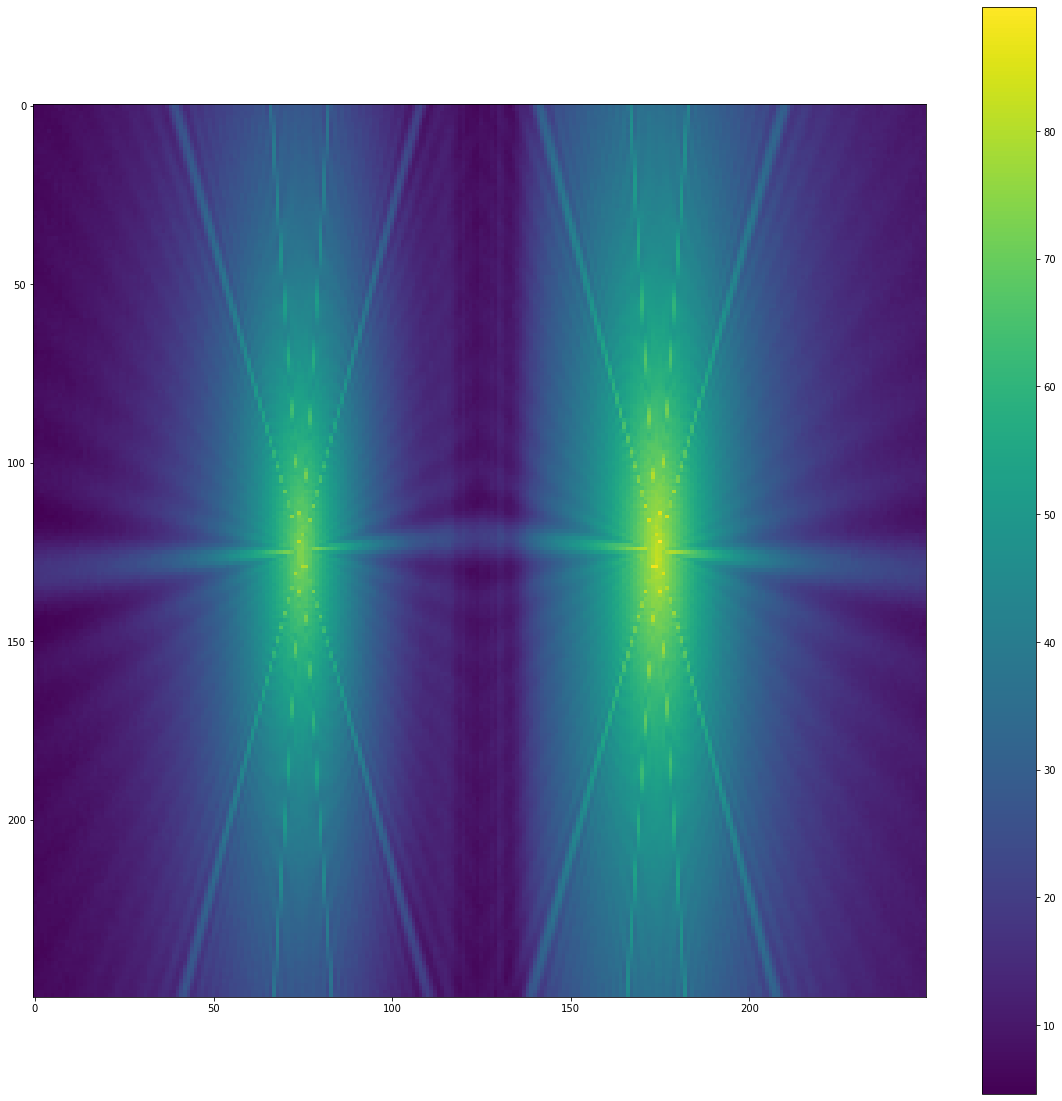

In [20]:
plt.figure(figsize=(20,20))
im = plt.imshow(only_filter[0][:,124])
plt.colorbar(im)

In [ ]:
halfslice_y = noisy_cart_filtered[0].shape[1]//2
halfslice_z = noisy_cart_filtered[0].shape[2]//2

fig_simple = plt.figure(figsize=(30,30))
axs_simple = fig_simple.subplots(2, 2)
im0 = axs_simple[0,0].imshow(noisy_cart_filtered[0][:,halfslice_y])
im1 = axs_simple[0,1].imshow(noisy_cart_filtered[0][halfslice_z])
im2 = axs_simple[1,0].imshow(noisy_cart_filtered[1][:,halfslice_y])
im3 = axs_simple[1,1].imshow(noisy_cart_filtered[1][halfslice_z])
fig_simple.colorbar(im0, ax = axs_simple[0])
fig_simple.colorbar(im2, ax = axs_simple[1])

In [6]:
psutil.virtual_memory()

svmem(total=33731371008, available=28613263360, percent=15.2, used=4390031360, free=28094726144, active=4209053696, inactive=908263424, buffers=1064960, cached=1245548544, shared=192065536, slab=130859008)

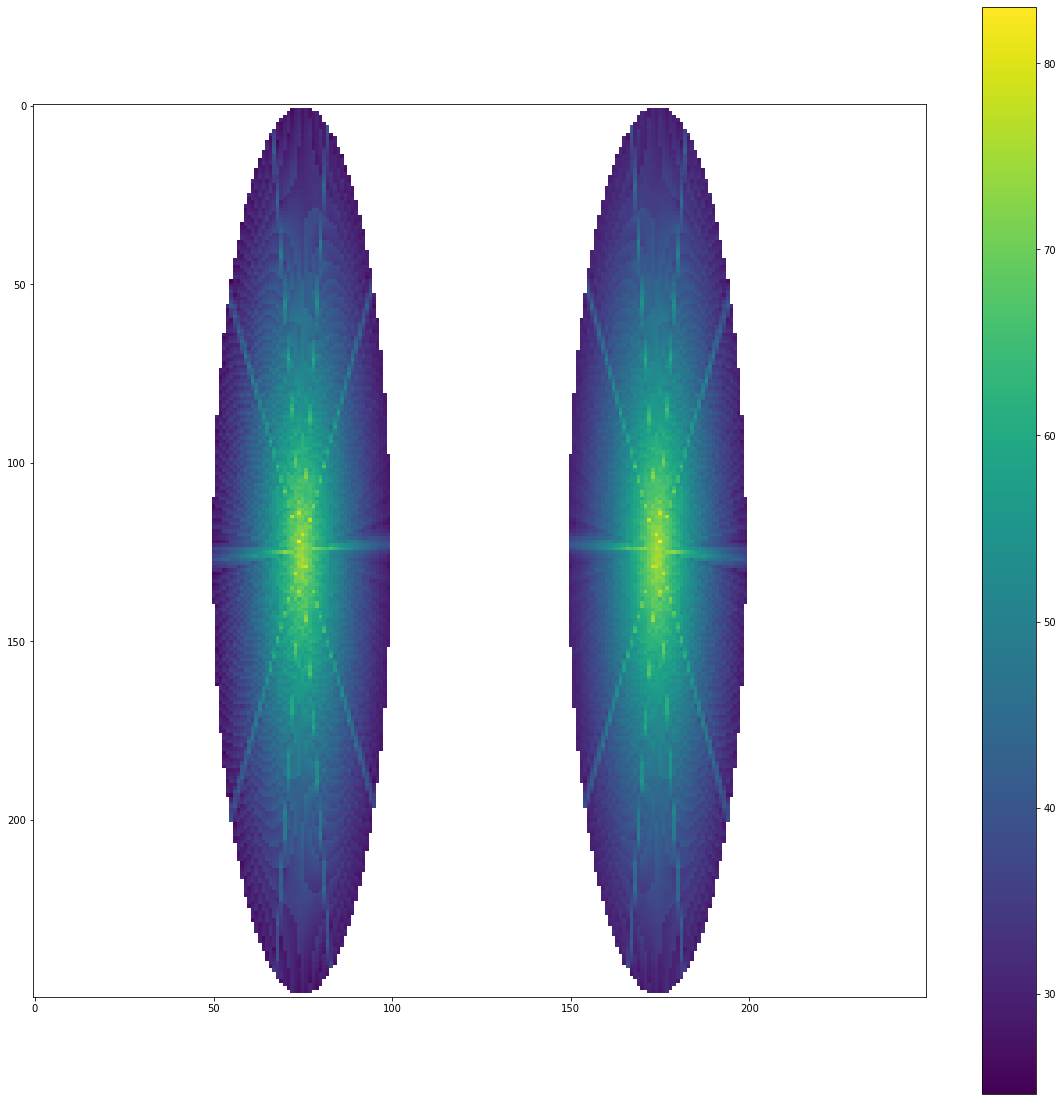

In [17]:
with open('%s/synthdata3/pmesh_cart_noisy_filtered_250'%cwd+'.npy', 'rb') as f:
    pmesh_denoised_250 = np.load(f)
f.close()

plt.figure(figsize=(20,20))
im = plt.imshow(pmesh_denoised_250[0][:,125])
plt.colorbar(im)

In [ ]:
"""with open('%s/synthdata3/ts_noisy_tor_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_tor = np.load(f)
f.close()

with open('%s/synthdata3/ts_noisy_tor_simp_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_tor_simp = np.load(f)
f.close()
"""
with open('%s/synthdata3/ts_cart_'%cwd+'%i.npy'%(250), 'rb') as f:
    noisy_cart = np.load(f)
f.close()

"""with open('%s/synthdata3/ts_cart_simp_'%cwd+'%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy_simp = np.load(f)
f.close()

with open('%s/synthdata3/ts_pmesh_cart_noisy'%cwd+'%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy = np.load(f)
f.close()"""

In [ ]:
truenoise = np.array([noisy_cart[i].T[::-1] - synthfield_cart.T[::-1] for i in range(len(noisy_cart))])

In [ ]:
with open('%s/synthdata3/pmesh_cart_noisy_filtered_'%cwd+'%i.npy'%(250), 'rb') as f:
    pmesh_cart_noisy_filtered = np.load(f)
f.close()

In [ ]:
with open('%s/synthdata3/only_filter_'%cwd+'%i.npy'%(250), 'rb') as f:
    only_filter = np.load(f)
f.close()

In [ ]:
noise_tor_mean = np.array(noisy_cart) - sum(noisy_cart)/len(noisy_cart)
noise_tor_filter = np.array([only_filter[i] - synthfield_cart.T[::-1] for i in range(len(only_filter))])
noise_tor_interpol_filter = np.array([pmesh_cart_noisy_filtered[i] - synthfield_cart.T[::-1] for i in range(len(pmesh_cart_noisy_filtered))])

In [ ]:
plt.imshow(pmesh_cart_noisy_filtered[0][:,124])

In [ ]:
plt.imshow(synthfield_cart.T[::-1][:,124])

In [ ]:
for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_filter_%i.npy'%(noise_tor_filter[0].shape[0], i), 'wb') as f_ts:
                np.save(f_ts, noise_tor_filter[i])
f_ts.close()

for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_interpol_filter_%i.npy'%(noise_tor_filter[0].shape[0], i), 'wb') as f_ts:
                np.save(f_ts, noise_tor_interpol_filter[i])
f_ts.close()

for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_mean_%i.npy'%(noise_tor_filter[0].shape[0], i), 'wb') as f_ts:
                np.save(f_ts, noise_tor_mean[i])
f_ts.close()

In [ ]:
"""noise_tor_filter = []
for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_filter_%i.npy'%(250, i), 'rb') as f_ts:
        temp_data = np.load(f_ts)
        noise_tor_filter.append(temp_data)
        del temp_data             
f_ts.close()
noise_tor_filter = np.array(noise_tor_filter)

noise_tor_mean = []
for i in range(20):
    with open('%s/synthdata3/ts_'%cwd+'%i_denoised_mean_%i.npy'%(250, i), 'rb') as f_ts:
        temp_data = np.load(f_ts)
        noise_tor_mean.append(temp_data)
        del temp_data             
f_ts.close()
noise_tor_mean = np.array(noise_tor_mean)"""

In [ ]:
noise_tor_mean.ravel().shape

In [ ]:
"""import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 500000000
"""
plt.plot(noise_tor_mean.ravel()[:int(1e4)], noise_tor_filter.ravel()[:int(1e4)], 'k.')
plt.xlabel('$\\theta_t - \\langle \\theta \\rangle$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t$')

In [ ]:
plt.plot(noise_tor_mean.ravel()[:int(1e4)], noise_tor_mean.ravel()[:int(1e4)], 'k.')
plt.ylabel('$\\theta_t - \\langle \\theta \\rangle$')
plt.xlabel('$\\epsilon$')

In [ ]:
plt.plot(truenoise.ravel()[:int(1e4)], noise_tor_filter.ravel()[:int(1e4)], 'k.')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t$')

In [ ]:
plt.plot(truenoise.ravel()[int(9e7):int(1e8)], noise_tor_interpol_filter.ravel()[int(9e7):int(1e8)], 'k.')
plt.xlabel('$\\epsilon$')
plt.ylabel('$\\theta_t - \\tilde{\\theta}_t^{(interpol)}$')

In [ ]:
std_filter = np.nanstd(noise_tor_filter.ravel())
std_mean = np.std(noise_tor_mean.ravel())
std_true = np.nanstd(truenoise.ravel())
print(std_filter)
print(std_mean)
print(std_true)